In [9]:
import matplotlib
#matplotlib.use('Agg')

%load_ext autoreload
%autoreload 2

#%matplotlib tk
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import os
import umap
import parmap
import sys
sys.path.append("/home/cat/code/widefield/") # go to parent dir


#
import glob2
import numpy as np
from sklearn.decomposition import PCA
from math import atan2

from shapely.geometry import Polygon
from shapely import geometry
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull


from matplotlib.path import Path
from sklearn.linear_model import LinearRegression
import scipy

# visualize results module
from visualize.visualize import get_sessions2
from visualize import PCA_Analysis
import pickle as pk

# 
#data_dir = '/media/cat/4TBSSD/yuki/'
data_dir = '/media/cat/4TBSSD/yuki/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [10]:
def generate_pca_umap_scatter_plots_sliding_window(start1, width, n_steps, data, data_r, umap_plot, fname):

    for k in range(n_steps):
        start = start1+k*width
        end = start+width
        data_all = data[:,:,start:end]
        data_all_r = data_r[:,:,start:end]

        if False:
            data_all = data_all.mean(1)
            data_all_r = data_all_r.mean(1)

        # average all singel trials
        mean = data_all.mean(0)

        print ("data_all: ", data_all.shape)
        print ("Mean: ", mean.shape)

        data_pca = data_all.reshape(data_all.shape[0],-1)
        print ("data_pca", data_pca.shape)

        data_pca_r = data_all_r.reshape(data_all.shape[0],-1)


        X = np.vstack((data_pca, data_pca_r))
        print ("data input: ", X.shape)


        #############################################
        #############################################
        #############################################
        #
        #if k==0:
        pca = PCA(n_components=2)
        pca.fit(X)


        p = pca.transform(X)
        print ("Pca output: ", p.shape)

        if umap_plot:
            import umap
            fit = umap.UMAP()
            %time u = fit.fit_transform(X)
            print ("Umap output: ", u.shape)


        # #######################################
        # ########### PLOT RESULTS ##############
        # #######################################

        dot_size = 100
        fig=plt.figure(figsize=(5,5))
        plt.scatter(p[:106,0],
                    p[:106,1],
                    s=dot_size,
                   c='blue',
                   alpha=.9,
                   label='lever')

        plt.scatter(p[106:,0],
                    p[106:,1],
                    c='black',
                    s=dot_size,
                    alpha=.9,
                    label='random')

        plt.legend()

        if True:
            plt.savefig('/home/cat/pca_fullvector_'+str(k-n_steps)+'.svg',dpi=1200)
            plt.close()
        else:
            plt.show()

        #ctr+=1

        if umap_plot:
            fig=plt.figure(figsize=(5,5))
            plt.scatter(u[:106,0],
                        u[:106,1],
                        s=dot_size,
                        c='blue',
                       alpha=.9)

            plt.scatter(u[106:,0],
                        u[106:,1],
                        s=dot_size,
                       c='black',
                       alpha=.9)

            plt.savefig('/home/cat/umap_fullvector_'+str(k-n_steps)+'.svg',dpi=1200)
            plt.close()
            
            
            
# 
def generate_var_explained_files_from_pkl(main_dir, animal_ids, session_id):
    #
    for animal_id in animal_ids: 
        sessions = get_sessions(main_dir,
                                 animal_id,
                                 session_id)

        # 
        for session in sessions:
            print ("session: ", session)

            # 
            fname_pca = os.path.join(main_dir,animal_id,'tif_files',session,
                                                 session+ '_whole_stack_trial_ROItimeCourses_15sec_pca.pkl')
            # 
            fname_out = fname_pca.replace('.pkl','_var_explained.npy')

            if os.path.exists(fname_out)==False:
                try:


                    file = open(fname_pca, 'rb')
                    pca = pk.load(file)

                    np.save(fname_out, pca.explained_variance_ratio_)
                except: 
                    print (" missing pkl file")
            print ('')
            
            
#   
def compute_and_plot_overlap_contours_body_parts(plotting, feature_ids,
                                                 animal_id, session):

    pa = PCA_Analysis()
    pa.root_dir = '/media/cat/4TBSSD/yuki/'
    pa.animal_id = [animal_id]

    # get the correct sesion name:
    sessions2, session_id = get_sessions2(pa.root_dir,
                                         animal_id,
                                         session)

    #
    n_trials = []
    n_left = []
    n_right = []
    areas = []
    right_lever_overlap = []

    #
    ctr_sess = 0
    for session in sessions2:
        #print ("ctr-sess: ", ctr_sess)
        ######################################################## 
        pa = PCA_Analysis()
        pa.root_dir = '/media/cat/4TBSSD/yuki/'
        pa.animal_id = [animal_id]
        pa.session = session

        # 
        pa.use_pca_data = True    # this uses the PCA denoised STMs not Raw data!
        pa.recompute = True
        pa.n_pca = 20
        pa.sliding_window = 30    # how many frames to take into analysis window
        pa.n_frames = 30          # how many frames back in time to analyze: 

        #########################################################
        # load all simplex results 
        fname_simplex = os.path.join(pa.root_dir, animal_id,'tif_files/res_simplex.npy')
        res_simplex = np.load(fname_simplex,allow_pickle=True)

        # get the correct sesion name:
        sessions, session_id = get_sessions2(pa.root_dir,
                                             animal_id,
                                             session)

        #print ("sessions: ", sessions, " session # ", session_id)

        if len(sessions)==1:
            res_simplex = [res_simplex[session_id]]
        else:
            res_simplex = res_simplex[session_id]

        areas.append([])

        # 
        right_lever_overlap.append([])

        # 
        for k in range(len(res_simplex)):
            if plotting:
                fig = plt.figure()
                ax=plt.subplot()

            #print ('len simplex start: ', len(res_simplex[k]))
            if len(res_simplex[k])==0:
                continue

            # n_lever trials
            try:
                n_trials = np.loadtxt(os.path.join(pa.root_dir, animal_id,'tif_files',
                                           sessions[k], sessions[k]+'_all_locs_selected.txt')).shape[0]
            except:
                continue

            #########################################
            polygons = []
            for a in feature_ids:
                simplex_2point = res_simplex[k][a]
                if len(simplex_2point)>0:

                    # 
                    if plotting:
                        linewidth=5
                        clr=clrs[a]
                        plot_convex_hull_function_2points(ax, simplex_2point,clr,linewidth)

                    # grab only unique points
                    temp = np.unique(np.vstack(simplex_2point),axis=0)
                    
                    # compute order of angles to origin
                    angles = []
                    C= [0,0]
                    for q in range(temp.shape[0]):
                        angle = atan2(temp[q][1]- C[1], 
                                      temp[q][0]- C[0])
                        angles.append(angle)
                    idx = np.argsort(angles)

                    # reorder coords clockwise for poology area computaoitn
                    temp = temp[idx]

                    # 
                    #pgon = Polygon(zip(temp[:,0], temp[:,1])) # Assuming the OP's x,y coordinates
                    area = PolyArea(temp[:,0],temp[:,1])

                    areas[ctr_sess].append(area)
                    
                    # save completed polygon
                    #temp = np.concatenate((temp, temp[-1]))
                    polygons.append(temp)
                    
                else:
                    areas[ctr_sess].append(np.nan)
                    polygons.append(np.nan)
                    
            #############################################################################
            # compute overlap between features 1 - right paw and 2- lever
            if np.any(np.isnan(polygons[1]))==False and np.any(np.isnan(polygons[2]))==False:
                print ("polygons[1]: ", polygons[1].shape)
                print ("polygons[2]: ", polygons[2].shape)

                # 
                x, y = np.meshgrid(np.arange(-1E3,1E3,1), 
                                   np.arange(-1E3,1E3,1)) # make a canvas with coordinates
                
                x, y = x.flatten(), y.flatten()
                points = np.vstack((x,y)).T 
                
                # compute area first polygon - right paw
                p = Path(polygons[1]/100.) # make a polygon
                grid = p.contains_points(points)

                mask1 = grid.reshape(2000,2000) 
                
                # compute area second polygon - lever
                p = Path(polygons[2]/100.) # make a polygon
                grid = p.contains_points(points)

                mask2 = grid.reshape(2000,2000) 
                idx_lever = np.where(mask2==1)[0]
                
                # sum polygons 
                mask3 = np.int32(mask1)+np.int32(mask2)
                #print ("unique: ", np.unique(mask3))
                
                # look at overlap
                idx = np.where(mask3==2)[0]
                print ("overlap size: ", idx.shape[0])

                area_overlap = idx.shape[0]
                
                area_lever = idx_lever.shape[0]
#                 fig=plt.figure()
# #                 plt.subplot(2,2,1)
# #                 plt.imshow(mask1)
                
# #                 plt.subplot(2,2,2)
# #                 plt.imshow(mask2)
                
#                 plt.subplot(2,2,3)
#                 plt.imshow(mask3)
            
#                 return
                
#                 plt.show()
                
                right_lever_overlap[ctr_sess]=area_overlap/area_lever
                    
            #############################################################################
            if plotting:
                title = sessions[k] + " # lever pulls " + str(n_trials)
                plt.title(title)


                import matplotlib.patches as mpatches

                handles = []
                for f in feature_ids:
                    # manually define a new patch 
                    patch = mpatches.Patch(color=clrs[f], label=names[f])

                    # handles is a list, so append manual patch
                    handles.append(patch) 

                # plot the legend
                plt.legend(handles=handles, fontsize=16)


        ctr_sess+=1

        #############################################################################
        if plotting:
            if True:
                plt.savefig("/home/cat/overlap_"+title+".svg")
                plt.close
            else:
                plt.show()
         
    print (" ... DONE ...")
    return areas, right_lever_overlap
 
    
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


In [22]:
##########################################################
#### GENERATE PCA DISTRIBUTIONS OF ALL BODY MOVEMENTS ####
##########################################################

#  Fig 3E 
pa = PCA_Analysis()
pa.root_dir = '/media/cat/4TBSSD/yuki/'
pa.n_pca = 10
pa.sliding_window = 30    # how many frames to take into analysis window
pa.n_frames = 1         # how many frames back in time to analyze: 

# 
pa.umap_flag = False
pa.convex_hull_flag = False

pa.frame_rate = 30

########################################
animal_ids = ['IA1','IA2','IA3','IJ1',"IJ2","AQ2"]
#animal_ids = ['IA2']
for animal_id in animal_ids:
    
    fname_out = os.path.join(pa.root_dir, animal_id,'tif_files',
                            'res_simplex.npy')

    if os.path.exists(fname_out)==False:
        pa.animal_id = animal_id
        session = 'all'

        pa.plot_all = True
        pa.plot_3D = False
        pa.plot_flag = False


        #########################
        # get the correct sesion name:
        sessions = get_sessions(pa.root_dir,
                                  pa.animal_id,
                                  session)

        #print ("sessions: ", sessions)
        # 
        res_simplex = pca_scatter_body_movements_fig3(pa, sessions)

        np.save(fname_out, res_simplex)
    
    
print (" COMPLETED: SESSIONS: ", )

 COMPLETED: SESSIONS: 


In [12]:
##################################################
### PLOT CONVEX HULLS FOR BODY PARTS VS LEVER ####
##################################################

# Fig 4
# NOTE THE DATA IS NOT 10% TRIAGED!?!? UNSURE 
animal_ids = ['IA1','IA2','IA3','IJ1',"IJ2","AQ2"]

# 
names = ['leftpaw','rightpaw','nose','jaw','ear','lever', 'all']
clrs=['red','blue','red','brown','black','magenta','black','green','red','brown' ]

# 
lefts = []
rights = []
levers = []
nTrials = []
areas = []
overlaps = []
for animal_id in animal_ids:
    
    # session = 'all'
    session = 'all'
    #session = 'Dec28_'#, "Jan14_", "Feb17_", "Apr21_"]  # PLOTS FOR FIG 4 J?!  from AQ2


    feature_ids = [0,1,5,6]

    plotting = False   # this flag == True gives the overlap contour plots

    #
    area, overlap = compute_and_plot_overlap_contours_body_parts(plotting, feature_ids,
                                                         animal_id, session)
    
    areas.append(area)
    overlaps.append(overlap)

    print ("done animal: ", animal_id)

polygons[1]:  (10, 2)
polygons[2]:  (6, 2)
overlap size:  21075
polygons[1]:  (8, 2)
polygons[2]:  (8, 2)
overlap size:  0
polygons[1]:  (9, 2)
polygons[2]:  (8, 2)
overlap size:  21041
polygons[1]:  (9, 2)
polygons[2]:  (6, 2)
overlap size:  100588
polygons[1]:  (15, 2)
polygons[2]:  (9, 2)
overlap size:  2945
polygons[1]:  (9, 2)
polygons[2]:  (7, 2)
overlap size:  104521
polygons[1]:  (11, 2)
polygons[2]:  (9, 2)
overlap size:  43384
polygons[1]:  (12, 2)
polygons[2]:  (7, 2)
overlap size:  27688
polygons[1]:  (13, 2)
polygons[2]:  (12, 2)
overlap size:  41337
polygons[1]:  (13, 2)
polygons[2]:  (6, 2)
overlap size:  61129
polygons[1]:  (9, 2)
polygons[2]:  (8, 2)
overlap size:  15815
polygons[1]:  (9, 2)
polygons[2]:  (5, 2)
overlap size:  33506
polygons[1]:  (9, 2)
polygons[2]:  (7, 2)
overlap size:  13989
polygons[1]:  (12, 2)
polygons[2]:  (5, 2)
overlap size:  60402
polygons[1]:  (7, 2)
polygons[2]:  (7, 2)
overlap size:  40350
polygons[1]:  (8, 2)
polygons[2]:  (7, 2)
overlap 

In [13]:
np.save('/home/cat/hull_areas.npy',areas)
np.save('/home/cat/hull_overlaps.npy',overlaps)


/media/cat/4TBSSD/anaconda3/envs/wide/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 cor:  (0.4720210670510704, 0.03073867279928841)
1 cor:  (0.17018000488100932, 0.7471943041554421)
2 cor:  (0.47262569276693916, 0.142096126047607)
3 cor:  (-0.6332602875836995, 0.049356283112943704)
4 cor:  (0.2528374822003362, 0.5115797202246466)
5 cor:  (0.6384853126848788, 9.294748655418108e-06)


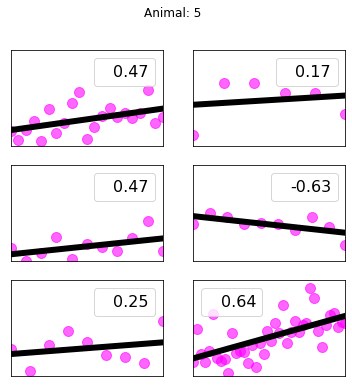

In [14]:
################################################
################################################
################################################
animal_ids = np.arange(6)

fig=plt.figure(figsize=(6,6))
clr='magenta'
for animal_id in animal_ids:
    ax = plt.subplot(3,2,animal_id+1)
    ctr=0
    data=[]
    for k in range(len(areas[animal_id])):
        flag = False
        try:
            area_right = areas[animal_id][k][2]
            area_all = areas[animal_id][k][3]
            temp = area_right/area_all
            if np.isnan(temp)==False:
                plt.scatter(ctr, temp, 
                            s=100, 
                            c=clr,
                           alpha=.6)                
                ctr+=1
                data.append([ctr,temp])
        except:
            pass
            
        #print (k, ctr)
        
    #    
    data = np.array(data)
    #print ("data: ", data.shape)
    
    # fit line
    x = data[:,0]
    y = data[:,1]
    corr = scipy.stats.pearsonr(x,y)
    print (animal_id, "cor: ", corr)

    
    # fit
    model = LinearRegression()
    y=np.array(y).reshape(-1, 1)
    x = np.arange(y.shape[0]).reshape(-1, 1)
    model.fit(x, y)

    x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
    y_pred = model.intercept_ + model.coef_ * x2

   
    plt.plot(x2, y_pred, label= str(round(corr[0],2)),
             c='black',
             linewidth=6)
    
    
    legend = plt.legend(handlelength=0, fontsize=16)        
    #plt.legend(fontsize=12)
    plt.xlim(x[0],x[-1])
    plt.ylim(np.min(y), np.max(y))
    #print (" COMPUTE PEARSON CORR NOT T-TEST ON FIT")
    #print (np.min(y), np.max(y))
    #plt.ylim(0,2)

    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,0.5)
            
    #print (k, ctr)
    plt.suptitle("Animal: "+ str(animal_id))
 

if False:
    plt.savefig('/home/cat/ratio.svg')
    plt.close()
else:
    plt.show()

<ipython-input-8-a5726c4958b3>:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.isnan(temp)==False:


NameError: name 'scipy' is not defined

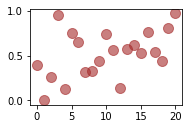

In [8]:
################################################
################################################
################################################
animal_ids = np.arange(6)

clr='brown'
fig = plt.figure(figsize=(6,6))
for animal_id in animal_ids:
    ax=plt.subplot(3,2,animal_id+1)
    ctr=0
    data= []
    for k in range(len(overlaps[animal_id])):
        #ax = plt.subplot(2,2,a+1)
        try:
            temp = overlaps[animal_id][k]
            if np.isnan(temp)==False:
                plt.scatter(ctr, temp, 
                            s=100, 
                            c=clr,
                           alpha=.6)
                ctr+=1
                data.append([ctr,temp])
        except:
            pass
        
    #    
    data = np.array(data)
    #print ("data: ", data.shape)
    
    # fit line
    x = data[:,0]
    y = data[:,1]
    corr = scipy.stats.pearsonr(x,y)
    print ("cor: ", corr)

    
    # fit
    model = LinearRegression()
    y=np.array(y).reshape(-1, 1)
    x = np.arange(y.shape[0]).reshape(-1, 1)
    model.fit(x, y)

    x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
    y_pred = model.intercept_ + model.coef_ * x2

   
    plt.plot(x2, y_pred, label= str(round(corr[0],2)),
             c='black',
             linewidth=6)
    
    
    legend = plt.legend(handlelength=0, fontsize=16)        
    #plt.legend(fontsize=12)
    plt.xlim(x[0],x[-1])
    plt.ylim(np.min(y), np.max(y))
    #print (" COMPUTE PEARSON CORR NOT T-TEST ON FIT")
    #print (np.min(y), np.max(y))
    #plt.ylim(0,2)

    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,1)
            
    #print (k, ctr)
    plt.suptitle("Animal: "+ str(animal_id))

if False:
    plt.savefig('/home/cat/overlap_fits.svg')
    plt.close()


areas[k]: [list([1544226526.9314482, 1601138774.5727801, nan, 7157798086.992378])
 list([1972198560.5312955, 1972903861.662909, 535286015.17681825, 6928879130.638285])
 list([4366489304.783436, 4494376122.836153, 423292644.953614, 13988169285.287395])
 list([])
 list([2117508237.4594605, 1994156968.270977, nan, 8409419295.623916])
 list([3213651261.9625225, 2871609429.8905025, 805301597.359238, 9426144072.959574])
 list([2008586668.7027335, 2074263069.6355352, 1056608749.0688086, 7949772585.270355])
 list([2561093423.6941686, 2435405067.4163733, 220024164.8524373, 8489973280.704967])
 list([1728860666.9588485, 1891525216.379481, nan, 5584811585.393196])
 list([2027669362.091145, 2069325372.8902464, 1386327283.498386, 7227209284.350147])
 list([2315450150.678129, 3156599892.522682, 664307745.4874948, 9645315740.718395])
 list([2364576243.054553, 2210725279.9615774, 863453807.2592303, 7298880058.813152])
 list([]) list([]) list([]) list([]) list([]) list([]) list([]) list([])
 list([]) l

[5.30709022e+09 4.65249648e+09 4.87684827e+09 6.02753007e+09
 4.45935049e+09 4.08171955e+09 4.46489543e+09 8.22004934e+09
 7.38968061e+09 9.96580327e+09 7.05810346e+09 7.94986367e+09
 5.18388141e+09 6.86337174e+09 6.98945776e+09 4.55835065e+09
 8.31093258e+09 4.78476317e+09 6.36228424e+09 4.72670236e+09
 4.74264904e+09 4.02354889e+09 7.11314719e+09 6.15877725e+09
 5.54659092e+09 4.67992563e+09 7.89736385e+09 8.02033897e+09
 6.88945704e+09 7.80209964e+09 8.15346992e+09 9.47789234e+09
 7.15592707e+09 7.91794779e+09 5.55089783e+09 9.03562782e+09
 1.00785797e+10 3.32948282e+09 2.30741079e+09 2.06474296e+09
 3.73665903e+09 3.85126402e+09 2.96022867e+09 6.31403477e+09]
cor:  (-0.07468481534879243, 0.6299373460594382)
 COMPUTE PEARSON CORR NOT T-TEST ON FIT


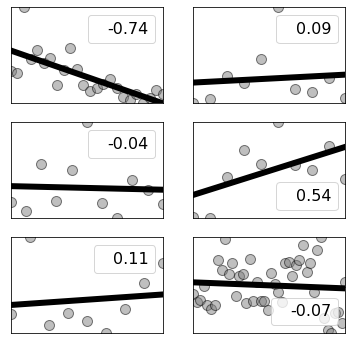

In [15]:
#############################################################
### PLOT SCATTER PLOTS OF LONGITUDINAL CONVEX AREA SPACE ####
#############################################################

fig = plt.figure(figsize=(6,6))

feature_id = 3   # 0: left paw;  1: right paw;  2: lever;  3: all
for k in range(len(areas)):
    ax=plt.subplot(3,2,k+1)
    
    temp = np.array(areas[k], dtype='object')
    print ("areas[k]:", temp, len(temp))
    temp2 = []
    for q in range(len(temp)):
        if len(temp[q])>0:
            temp3 = temp[q][feature_id]
            print ("temp3: ", temp3)
            temp2.append(temp3)

    temp = np.hstack(temp2)
    print (temp)
    plt.scatter(np.arange(len(temp)), temp,
                c='grey',
                edgecolor='black',
                s=100,
                alpha=.5)

    x = np.arange(len(temp))
    corr = scipy.stats.pearsonr(x,temp)
    print ("cor: ", corr)

    
    # fit
    model = LinearRegression()
    y=np.array(temp).reshape(-1, 1)
    x = np.arange(y.shape[0]).reshape(-1, 1)
    model.fit(x, y)

    x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
    y_pred = model.intercept_ + model.coef_ * x2

   
    plt.plot(x2, y_pred, label= str(round(corr[0],2)),
             c='black',
             linewidth=6)
    
    
    
    legend = plt.legend(handlelength=0, fontsize=16)        
    #plt.legend(fontsize=12)
    plt.xlim(x[0],x[-1])
    plt.ylim(np.min(y), np.max(y))
    print (" COMPUTE PEARSON CORR NOT T-TEST ON FIT")
    #print (np.min(y), np.max(y))
    #plt.ylim(0,2)

    plt.xticks([])
    plt.yticks([])

if False:
    plt.savefig('/home/cat/convex_hull_fits.svg')
    plt.close()
else:
    plt.show()












In [95]:


# tupVerts=np.random.rand(10,2)*100


# x, y = np.meshgrid(np.arange(300), np.arange(300)) # make a canvas with coordinates
# x, y = x.flatten(), y.flatten()
# points = np.vstack((x,y)).T 

# p = Path(tupVerts) # make a polygon
# grid = p.contains_points(points)

# mask = grid.reshape(300,300) 

# plt.imshow(mask)


                

No handles with labels found to put in legend.


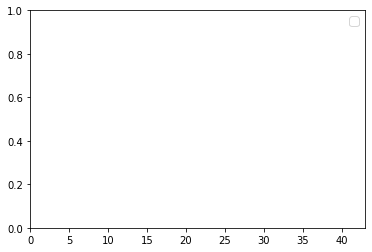

In [16]:
##########################################
######## OVERLAP POLYGON RATIOS ##########
##########################################

# Fig 3J

from sklearn.linear_model import LinearRegression


def find_p_t(model, X, y, X2, y_pred):
    #self = super(LinearRegression, self).fit(X, y, n_jobs)
    #print (self)

    #print (y_pred.shape, y.shape)
    sse = np.sum((y_pred - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    
    #print (sse)
    se = np.array([
        np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                for i in range(sse.shape[0])
                ])

    t = model.coef_ / se
    p = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - X.shape[1]))
    
    return t, p


clrs=['black','blue','red','green','magenta','pink']
sig = [0.05,0.01,0.001, 0.0001, 0.00001]
animal_ids = ['M1','M2','M3','M4','M5','M6']

fig=plt.figure()
for k in range(len(lefts)):
    temp = levers[k]
    
    # normalize to n trials per session
    if True:
        temp = temp/nTrials[k]
        
    print (temp.shape)
    
        
    idx = np.where(np.isnan(temp)==False)[0]
    #t=t[idx]
    temp=temp[idx]
    
    
    idx = np.where(temp!=0)[0]
    #t=t[idx]
    temp=temp[idx]
    
    
    model = LinearRegression()
    y=np.array(temp).reshape(-1, 1)
    x = np.arange(y.shape[0]).reshape(-1, 1)
    model.fit(x, y)

    x2 = np.arange(0,y.shape[0],1).reshape(-1, 1)
    y_pred = model.intercept_ + model.coef_ * x2


    t,p = find_p_t(model, x, y, x2, y_pred)
    
    temp_sig = ''
    for j in range(len(sig)):
        if p <= sig[j]:
            temp_sig = temp_sig+"*"
            
    
    plt.plot(x2, y_pred, label=animal_ids[k]+ " "+temp_sig,
             c=clrs[k],
            linewidth=6)
    
    
    
    t = np.arange(temp.shape[0])
    plt.scatter(t,temp,
                s=100,
                edgecolor='black',
               c=clrs[k],
               alpha=.7)

    
plt.legend(fontsize=12)
plt.xlim(0,43)
plt.ylim(bottom=0)
            
plt.show()

In [139]:
import sphviewer as sph
from numpy.ma import masked_array

def myplot(x, y, nb=32, xsize=500, ysize=500):   
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    x0 = (xmin+xmax)/2.
    y0 = (ymin+ymax)/2.

    pos = np.zeros([len(x),3])
    pos[:,0] = x
    pos[:,1] = y
    w = np.ones(len(x))

    P = sph.Particles(pos, w, nb=nb)
    S = sph.Scene(P)
    S.update_camera(r='infinity', x=x0, y=y0, z=0, 
                    xsize=xsize, ysize=ysize)
    R = sph.Render(S)
    R.set_logscale()
    img = R.get_image()
    extent = R.get_extent()
    for i, j in zip(range(4), [x0,x0,y0,y0]):
        extent[i] += j
    print (extent)
    
    
    clrs = np.unique(img)
    img_out = np.zeros(img.shape,'float32')
    for k in range(clrs.shape[0]):
        idx = np.where(img==clrs[k])
        print (k)
        img_out[idx]=k
    
    return img_out, extent

# Generate Lever locations
print (pa.p_lever.shape)
x = pa.p_lever.squeeze()[:,0]
y = pa.p_lever.squeeze()[:,1]
x_size = 100
y_size = 100
heatmap_lever, extent_lever = myplot(x,y, nb=4, xsize=x_size, ysize=y_size)

print ("npm ax: ", np.max(heatmap_lever), np.min(heatmap_lever))
print (np.unique(heatmap_lever))

v1_lever = masked_array(heatmap_lever,
                   heatmap_lever>=1)

# Generate left paw locations
print (pa_array[0].shape)
x = pa_array[0].squeeze()[:,0]
y = pa_array[0].squeeze()[:,1]
x_size = 100
y_size = 100
heatmap_leftpaw, extent_left_paw = myplot(x,y, nb=4, xsize=x_size, ysize=y_size)

print ("npm ax: ", np.max(heatmap_leftpaw), np.min(heatmap_leftpaw))
print (np.unique(heatmap_leftpaw))



fig,ax = plt.subplots()

#ax4.imshow(heatmap_64, 
ax1=plt.subplot(121)  
p1 = ax1.imshow(heatmap_lever,
               extent=extent_lever, 
               #origin='lower', 
               aspect='auto',
               cmap='Reds')

plt.xlim(-40000,60000)
plt.ylim(-50000,50000)

#cba = plt.colorbar(pa,shrink=0.25)

# 
ax2=plt.subplot(122)  
# v1_leftpaw = masked_array(heatmap_leftpaw,
#                           heatmap_leftpaw>=1)
p2 = ax2.imshow(heatmap_leftpaw, 
               extent=extent_left_paw, 
               #origin='lower', 
               aspect='auto',
               cmap='Greys')

plt.xlim(-40000,60000)
plt.ylim(-50000,50000)


#cbb = plt.colorbar(pb,shrink=0.25)
#plt.xlabel('Day')
#plt.ylabel('Depth')
#cba.set_label('positive')
#cbb.set_label('negative')
#plt.show()



plt.show()



(1, 31, 10)
[-41973.54    8432.656 -18250.133  34552.848]
0
1
2
npm ax:  2.0 0.0
[0. 1. 2.]
(1, 55, 10)
[-34157.016 265766.25  -61826.69   18024.137]
0
1
2
3
4
npm ax:  4.0 0.0
[0. 1. 2. 3. 4.]


In [90]:
all_points = np.load('/media/cat/4TBSSD/yuki/IJ2/tif_files/IJ2pm_Feb1_30Hz/IJ2pm_Feb1_30Hz_all_points.npy')
print (all_points.shape)

plt.scatter(all_points[:,0],
           all_points[:,1])
plt.show()

(1297, 10)


In [39]:
data = np.load('/media/cat/4TBSSD/yuki/IA1/tif_files/IA1pm_Feb1_30Hz/IA1pm_Feb1_30Hz_simplex.npy',
              allow_pickle=True)
print (data.shape)

for k in range(len(data)):
    print (k, len(data[k]), data[k])
    print ('')
    print ('')
    print ('')
    
    

(7,)
0 10 [[[-22296.67402998   4076.50235317]
  [-24952.34178691 -12521.8821865 ]]

 [[ 27179.59984132  15243.61265381]
  [ 36387.3380217   11594.16071859]]

 [[ 27179.59984132  15243.61265381]
  [  6527.78414207  18132.31999766]]

 [[ 12569.90409133 -15790.70530718]
  [ 24923.71341024 -13087.26890332]]

 [[ 29818.73556516  -4474.07065768]
  [ 36387.3380217   11594.16071859]]

 [[ 29818.73556516  -4474.07065768]
  [ 24923.71341024 -13087.26890332]]

 [[  3844.3651655   17625.96017483]
  [  6527.78414207  18132.31999766]]

 [[  3844.3651655   17625.96017483]
  [-22296.67402998   4076.50235317]]

 [[-23760.99648364 -14035.87313865]
  [-24952.34178691 -12521.8821865 ]]

 [[-23760.99648364 -14035.87313865]
  [ 12569.90409133 -15790.70530718]]]



1 10 [[[-17480.34267173   8522.70538265]
  [ -2666.46507497  15706.18174011]]

 [[ 27676.76364997   9666.84204692]
  [ 39197.38412352   2904.92268434]]

 [[ 27676.76364997   9666.84204692]
  [ -2666.46507497  15706.18174011]]

 [[-15063.08988346 -